# Stock Data Analysis Project

## Description
This project involves scraping stock market data and performing analysis to determine the best stocks to purchase. It utilizes various libraries to fetch data, visualize trends, and provide insights into stock performance.

## Installation
To set up the project, create a virtual environment and install the required packages using the [requirements.txt] file.

```bash
pip install -r requirements.txt

<div class="alert alert-info">
    <strong>Importing Modules</strong>
</div>

In [67]:
from datetime import datetime, timedelta
import numpy as np
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
from lxml import html
import re
import matplotlib.pyplot as plt
from ipywidgets import interactive, Dropdown, Checkbox
import ipywidgets as widgets
import os
import seaborn as sns
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.express as px
import plotly.graph_objects as go
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info">
    <strong>1. Data Scrapping:  <a href="https://www.prnewswire.com/news-releases/news-releases-list">Data Source</a></strong>
</div>


In [68]:

count = 30

def create_urls():
    current_date = datetime.now()
    month = current_date.month
    date = current_date.day
    year = current_date.year

    urls = []

    for i in range(count):
        current_date = datetime(year, month, date) - timedelta(days=i)
        current_month = current_date.month
        current_day = current_date.day
        current_year = current_date.year
        website_url = f"https://www.prnewswire.com/news-releases/news-releases-list/?month={current_month}&day={current_day}&year={current_year}&hour=00"
        urls.append(website_url)

    return urls

seven_days_urls = create_urls()


tickers_dir = os.path.join(os.getcwd(), 'tickers')
os.makedirs(tickers_dir, exist_ok=True)
page_content_path = os.path.join(tickers_dir, 'PageContent.txt')

for day, each_day_url in enumerate(seven_days_urls):
    day += 1

    with open(page_content_path, 'w', encoding='utf-8') as writer:
        writer.write('Page Url:' + each_day_url + '/n')
        response = requests.get(each_day_url).text
        tree = html.fromstring(response)
        list_of_articles = tree.xpath('//*[@class="row newsCards"]')

        print(f"Scrapping for {day} out of {count} days, Day {day} has {len(list_of_articles)} articles")

        for article in list_of_articles:
            snippet = html.tostring(article)
            soup = BeautifulSoup(snippet, 'html.parser')

            full_news_page = soup.find('a', class_='newsreleaseconsolidatelink')
            href_value = full_news_page.get('href')
            parse_page_url = 'https://www.prnewswire.com'+ href_value
            news_content = requests.get(parse_page_url).text
            source = BeautifulSoup(news_content, 'html.parser')
            paragraphs = source.select('div.col-lg-10.col-lg-offset-1 p')

            for paragraph in paragraphs:
                writer.write(paragraph.get_text() + '\n')

            writer.write('____________________________________________________________________' + '/n')

Scrapping for 1 out of 30 days, Day 1 has 23 articles
Scrapping for 2 out of 30 days, Day 2 has 23 articles
Scrapping for 3 out of 30 days, Day 3 has 23 articles
Scrapping for 4 out of 30 days, Day 4 has 23 articles
Scrapping for 5 out of 30 days, Day 5 has 23 articles
Scrapping for 6 out of 30 days, Day 6 has 23 articles
Scrapping for 7 out of 30 days, Day 7 has 23 articles
Scrapping for 8 out of 30 days, Day 8 has 23 articles
Scrapping for 9 out of 30 days, Day 9 has 23 articles
Scrapping for 10 out of 30 days, Day 10 has 23 articles
Scrapping for 11 out of 30 days, Day 11 has 23 articles
Scrapping for 12 out of 30 days, Day 12 has 23 articles
Scrapping for 13 out of 30 days, Day 13 has 23 articles
Scrapping for 14 out of 30 days, Day 14 has 23 articles
Scrapping for 15 out of 30 days, Day 15 has 23 articles
Scrapping for 16 out of 30 days, Day 16 has 23 articles
Scrapping for 17 out of 30 days, Day 17 has 23 articles
Scrapping for 18 out of 30 days, Day 18 has 23 articles
Scrapping 

In [69]:
def find_ticker_symbols(text):
    pattern = r'(\([a-zA-Z]+:\s*[a-zA-Z]+\s*[0-9]*\))'
    matches = re.findall(pattern, text)
    return matches

file_path = 'PageContent.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    file_content = file.read()

ticker_symbols = find_ticker_symbols(file_content)
symbols = list(set(ticker_symbols))



if ticker_symbols:
    print("Found ticker symbols:", symbols)
else:
    print("No ticker symbols found.")

Found ticker symbols: ['(NASDAQ: TTD)', '(OTC:KLYG)', '(NASDAQ: MPWR)', '(OTCQB:RGTLF)', '(NASDAQ:SNEX)', '(ASX: RGT)', '(NASDAQ: FTAI)', '(NYSE: MRK)', '(OTC: KLYG)', '(NASDAQ: MRVI)', '(ASX:RGT)', '(NASDAQ: NMRA)', '(NASDAQ: SWKS)', '(NASDAQ: SMTC)', '(OTCQB: RGTLF)', '(NYSE: ATKR)']



<div class="alert alert-info">
    <strong>2. Retrieving Data (Web (API)) &  Data Visualization</strong>
</div>


In [70]:
ticker_list = []
for ticker in symbols:
    t_name = ticker.split(':')[1].strip()[:-1]
    #limiting the stock to count of 3 as per pdf from professor
    # if len(ticker_list)<3:
    ticker_list.append(t_name)

In [71]:
def dataFrame(symbol):
    try:
        # Download data
        df = yf.download(symbol, start='2025-03-01', end='2025-03-31')
        if df.empty:
            print(f"No data available for {symbol} in the specified date range.")
            return df
        
        # Ensure 'tickers' directory exists
        ticker_dir = os.path.join(os.getcwd(), 'tickers')
        os.makedirs(ticker_dir, exist_ok=True)
        
        # Reset index to make 'Date' a column
        df = df.reset_index()
        
        # Ensure expected columns are present and in order
        expected_cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        missing_cols = [col for col in expected_cols if col not in df.columns]
        if missing_cols:
            print(f"Warning: Missing columns in {symbol}: {missing_cols}")
        
        # Reorder columns (keep only those present)
        ordered_cols = [col for col in expected_cols if col in df.columns]
        df = df[ordered_cols]
        
        # Save to CSV in tickers folder
        csv_path = os.path.join(ticker_dir, f'{symbol}.csv')
        df.to_csv(csv_path, index=False)
        print(f"Data downloaded successfully for Ticker: {symbol}, Stored in {csv_path}")
        return df
    except Exception as e:
        print(f"Error downloading data for {symbol}: {e}")
        return None

In [72]:
# Saving Each ticker's Dataframe to directory
for col in ticker_list:
    dataFrame(col)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully for Ticker: TTD, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\TTD.csv



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data downloaded successfully for Ticker: KLYG, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\KLYG.csv
Data downloaded successfully for Ticker: MPWR, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\MPWR.csv
Data downloaded successfully for Ticker: RGTLF, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\RGTLF.csv
Data downloaded successfully for Ticker: SNEX, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\SNEX.csv
Data downloaded successfully for Ticker: RGT, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\RGT.csv


[*********************100%***********************]  1 of 1 completed

Data downloaded successfully for Ticker: FTAI, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\FTAI.csv



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully for Ticker: MRK, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\MRK.csv
Data downloaded successfully for Ticker: KLYG, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\KLYG.csv
Data downloaded successfully for Ticker: MRVI, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\MRVI.csv
Data downloaded successfully for Ticker: RGT, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\RGT.csv
Data downloaded successfully for Ticker: NMRA, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\NMRA.csv
Data downloaded successfully for Ticker: SWKS, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\SWKS.csv



[*********************100%***********************]  1 of 1 completed

Data downloaded successfully for Ticker: SMTC, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\SMTC.csv



[*********************100%***********************]  1 of 1 completed

Data downloaded successfully for Ticker: RGTLF, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\RGTLF.csv
Data downloaded successfully for Ticker: ATKR, Stored in a:\EDUCATION\AI-ML\AIDI_1100\Assignments\Final_Project\tickers\ATKR.csv


In [73]:
def get_csv_files():
    tickers_dir = os.path.join(os.getcwd(), 'tickers')
    if not os.path.exists(tickers_dir):
        return []
    return [f for f in os.listdir(tickers_dir) if f.endswith(".csv")]

ticker_list = [f.split('.')[0] for f in get_csv_files()]

def plot_stock(symbol, line_style, plot_close, plot_volume):
    tickers_dir = os.path.join(os.getcwd(), 'tickers')
    filename = os.path.join(tickers_dir, f"{symbol}.csv")
    
    if not os.path.exists(filename):
        print(f"CSV file for {symbol} not found in 'tickers' folder.")
        return
    
    df = pd.read_csv(filename)
    # Clean column names
    df.columns = df.columns.str.strip()
    # Try to parse 'Date' column as datetime if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    else:
        print(f"'Date' column not found in {filename}. Columns: {df.columns.tolist()}")
        return
    
    if df.empty:
        print(f"Empty DataFrame for {symbol}.")
        return

    plt.figure(figsize=(10, 5))
    if plot_close and 'Close' in df.columns:
        plt.plot(df.index, df['Close'], label=f'{symbol} Close', linestyle=line_style)
    if plot_volume and 'Volume' in df.columns:
        plt.plot(df.index, df['Volume'], label=f'{symbol} Volume', linestyle=line_style)
    plt.title('Close Prices and Volume of Selected Companies')
    plt.xlabel('Date')
    plt.ylabel('Price / Volume')
    plt.xticks(rotation=30)
    plt.legend()
    plt.show()

symbol_dropdown = Dropdown(options=ticker_list, description='Ticker:')
line_style_dropdown = Dropdown(options=['solid', 'dashed', 'dashdot', 'dotted'], description='Line Style:')
plot_close_checkbox = Checkbox(value=True, description='Plot Close')
plot_volume_checkbox = Checkbox(value=True, description='Plot Volume')

interactive_plot = interactive(
    plot_stock,
    symbol=symbol_dropdown,
    line_style=line_style_dropdown,
    plot_close=plot_close_checkbox,
    plot_volume=plot_volume_checkbox
)

output = interactive_plot.children[-1]
output.layout.height = '500px'

interactive_plot

interactive(children=(Dropdown(description='Ticker:', options=('ATKR', 'FTAI', 'KLYG', 'MPWR', 'MRK', 'MRVI', …

<div class="alert alert-info">
    <strong>3. Extra Mile & Optional Code (stocks worth purchasing or not)</strong>
</div>

In [74]:
tickers_dir = os.path.join(os.getcwd(), 'tickers')
csv_files = [file for file in os.listdir(tickers_dir) if file.endswith('.csv')]
close_df = pd.DataFrame()

for csv_file in csv_files:
    file_path = os.path.join(tickers_dir, csv_file)
    # Skip the second row which contains repeated headers (as seen in ATKR.csv)
    df = pd.read_csv(file_path, skiprows=[1])
    print(f"Columns in {csv_file}: {df.columns.tolist()}")  # Debug: print columns

    # Strip whitespace from column names
    df.columns = df.columns.str.strip()

    # Find 'Date' column (case-insensitive)
    date_col = None
    for col in df.columns:
        if col.lower() == 'date':
            date_col = col
            break
    if date_col is None:
        raise KeyError(f"'Date' column not found in {csv_file}. Available columns: {df.columns.tolist()}")

    # Find 'Close' column (case-insensitive)
    close_col = None
    for col in df.columns:
        if col.lower() == 'close':
            close_col = col
            break
    if close_col is None:
        raise KeyError(f"'Close' column not found in {csv_file}. Available columns: {df.columns.tolist()}")

    # Set 'Date' as index and add 'Close' to close_df
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    ticker_name = csv_file.split('.')[0]
    close_df[ticker_name] = df[close_col]

print(close_df)

Columns in ATKR.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in FTAI.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in KLYG.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in MPWR.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in MRK.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in MRVI.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in NMRA.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in RGT.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in RGTLF.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in SMTC.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in SNEX.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in SWKS.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Columns in TTD.csv: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
                 ATKR        FTAI  KLYG        MPWR        MRK   M

In [75]:
tickers_dir = os.path.join(os.getcwd(), 'tickers')
os.makedirs(tickers_dir, exist_ok=True)
close_df.index.name = 'Date'
close_df.to_csv(os.path.join(tickers_dir, 'All_Ticker_Close_Price.csv'))

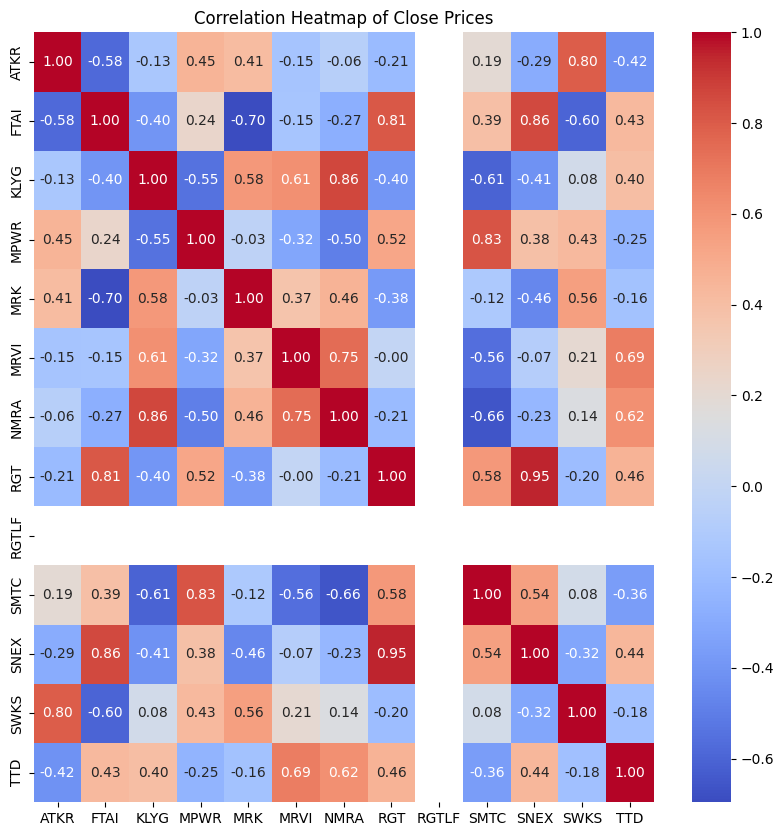

In [76]:
plt.figure(figsize=(10, 10))
sns.heatmap(close_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Close Prices')
plt.show()

In [77]:
close_df.head()

,ATKR,FTAI,KLYG,MPWR,MRK,MRVI,NMRA,RGT,RGTLF,SMTC,SNEX,SWKS,TTD
Date,,,,,,,,,,,,,
2025-03-03,58.889999,118.258316,0.26,577.362610,92.352165,3.02,1.405,10.75,0.0577,35.580002,82.146667,65.550003,67.169998
2025-03-04,59.240002,114.818550,0.24,586.567810,91.767212,2.84,1.410,10.72,0.0577,36.049999,78.673332,66.019997,67.599998
2025-03-05,62.310001,112.794563,0.27,610.543152,92.391823,2.81,1.430,10.79,0.0577,36.840000,80.146667,67.389999,66.540001
2025-03-06,64.699997,107.958946,0.26,564.178223,93.194885,2.67,1.520,10.63,0.0577,32.330002,78.166664,66.930000,64.980003
2025-03-07,64.870003,103.910988,0.25,595.184509,93.839317,2.96,1.490,10.61,0.0577,33.500000,76.639999,72.610001,64.910004


<div class="alert alert-success">
    <strong>3.1. Suggesting Ticker Using Simple Maths</strong>
</div>

In [78]:
percentage_change = close_df.pct_change() * 100
threshold = 5
worth_purchasing = abs(percentage_change) > threshold

max_true_count = 0
max_true_column = None

for col in worth_purchasing.columns:
    value_counts = worth_purchasing[col].value_counts()
    
    if True in value_counts.index:
        true_count = value_counts[True]
        
        if true_count > max_true_count:
            max_true_count = true_count
            max_true_column = col

if max_true_column is not None:
    print(f"The column with the maximum number of True values is: '{max_true_column}' which may be worth purchasing")
else:
    print("No True values found in any column.")


The column with the maximum number of True values is: 'NMRA' which may be worth purchasing


<div class="alert alert-success">
    <strong>3.2 (Suggesting) Using Arima Model</strong>
</div>

In [79]:
for column in close_df.columns:
    fig = px.line(y=close_df[column], x=close_df.index)
    fig.update_layout(title_text='None',font=dict(size=12),
                     xaxis_title_text="Date", yaxis_title_text=column)
    fig.show()

In [80]:
model_train=close_df.iloc[:int(close_df.shape[0]*0.80)]
valid=close_df.iloc[int(close_df.shape[0]*0.80):]
y_pred=valid.copy()

In [81]:
y_pred

,ATKR,FTAI,KLYG,MPWR,MRK,MRVI,NMRA,RGT,RGTLF,SMTC,SNEX,SWKS,TTD
Date,,,,,,,,,,,,,
2025-03-25,64.199997,116.940002,0.18,631.267212,87.870003,2.30,1.14,10.77,0.0577,40.070000,81.610001,68.220001,62.000000
2025-03-26,62.950001,114.000000,0.18,598.854614,88.110001,2.37,1.09,10.68,0.0577,38.689999,79.720001,67.599998,58.799999
2025-03-27,62.330002,114.519997,0.18,599.822021,87.599998,2.35,1.10,10.69,0.0577,36.950001,78.599998,66.300003,57.259998
2025-03-28,60.590000,112.360001,0.20,578.330017,89.230003,2.36,1.03,10.52,0.0577,35.049999,76.120003,64.120003,55.849998


In [82]:
for column in close_df.columns:
    model_arima= auto_arima(model_train[column],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=5,max_q=5,
                  suppress_warnings=True,stepwise=False,seasonal=False)
    model_arima.fit(model_train[column])

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=180.260, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=75.992, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.20 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0

In [83]:
for column in close_df.columns:
    prediction_arima=model_arima.predict(len(valid))
    y_pred["ARIMA Model Prediction"]=prediction_arima
    
    mse_arima= mean_squared_error(y_pred[column],y_pred["ARIMA Model Prediction"])
    rmse_arima=np.sqrt(mean_squared_error(y_pred[column],y_pred["ARIMA Model Prediction"]))
    mae_arima=mean_absolute_error(y_pred[column],y_pred["ARIMA Model Prediction"])
    print(len(prediction_arima))

4
4
4
4
4
4
4
4
4
4
4
4
4


In [84]:
model_scores_mse,model_scores_rmse,model_scores_mae = [],[],[]

In [85]:

model_scores_mse.append(mse_arima)
model_scores_rmse.append(rmse_arima)
model_scores_mae.append(mae_arima)


print("Mean Square Error ARIMA: ",mse_arima)
print("Root Mean Square Error ARIMA: ",rmse_arima)
print("Mean Absoulute Error ARIMA: ",mae_arima)

Mean Square Error ARIMA:  13.362755150564048
Root Mean Square Error ARIMA:  3.655510244899342
Mean Absoulute Error ARIMA:  3.2653373546664692


In [86]:
for column in close_df.columns:
    fig=go.Figure()
    fig.add_trace(go.Scatter(x=model_train.index, y=model_train[column], mode='lines',name="Train Data for Stock Prices"))
    fig.add_trace(go.Scatter(x=valid.index, y=valid[column], mode='lines',name="Validation Data for Stock Prices",))
    fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"], mode='lines',name="Prediction for Stock Prices",))
    fig.update_layout(title="ARIMA",xaxis_title="Date",yaxis_title=column,legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=12))
    fig.show()